In [89]:
## Dataset Things
from data.volumes import Volume, Page, Line
from data.graphset import Graphset
from data.graph_sampler import AttributeSampler
from data.ced_dataset import CEDDataset
from data.esposalles_dataset import EsposallesDataset
from data.iam_dataset import IAMDataset
from data.washington_dataset import WashingtonDataset
import data.volumes as dv

## Model Things
from models import visual_encoders as VE



### Utils
import utils 
import visualizations as visu

## Pipelines
import pipelines as pipes


## Common packages
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import torchvision
from torch.optim import Adam


## Typing Packages
from typing import *
from jaxtyping import Float, Array

## Configuration Package
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra.utils import instantiate
from hydra import initialize, compose

## Experiment Tracking packages
import wandb
import tqdm


## Common packages
import os
import matplotlib.pyplot as plt
import pickle
import numpy as np
from beeprint import pp as bprint
import pdb
from math import ceil


device = "cuda" if torch.cuda.is_available() else "cpu"

In [90]:
with initialize(version_base="1.3.2", config_path="./configs"):
    CFG = compose(config_name="pretrain", return_hydra_config=True)
    


In [91]:
CFG_MODELS = CFG.models
CFG_DATA = CFG.data
CFG_SETUP    = CFG.setup

In [92]:
#  ^ Hydra things
epochs = CFG_SETUP.configuration.epochs
batch_size = CFG_DATA.collator.batch_size
shuffle = CFG_DATA.collator.shuffle
checkpoint_name = CFG_MODELS.name_checkpoint
partitions_ratio = CFG_DATA.collator.partitions_ratio
# ^ 

In [93]:
# *Extracting the Datasets
means_width = []
means_heigth = []
list_of_datasets = []

for dataset_object in (CFG_DATA.datasets):
    data = instantiate(CFG_DATA.datasets[dataset_object])
    list_of_datasets.append(data)
    means_heigth.append(np.mean(data.line_heights))
    means_width.append(np.mean(data.line_widths))

standarized_width = ceil(np.mean(means_width))
standarized_height = ceil(np.mean(means_heigth))

for dts in list_of_datasets:
    dts.define_transforms((standarized_height, standarized_width))


if len(list_of_datasets) == 1:
    print("Only training with one Dataset")
    merged_dataset = list_of_datasets[-1]
else:
    merged_dataset = torch.utils.data.ConcatDataset(list_of_datasets)


collate_fn = list_of_datasets[0].collate_fn

generator = torch.Generator().manual_seed(2)
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(merged_dataset, partitions_ratio, generator=generator)
    # *

DOWNLOADING WASHINGTON LINES


     100%|██████████| 656/656 [00:00<00:00, 5414.03it/s]

Only training with one Dataset


In [112]:
infer_dataloader =  DataLoader(merged_dataset, batch_size=1, shuffle=False, pin_memory=True, num_workers=1, collate_fn=collate_fn)

## Model

In [95]:
model = VE.LineAutoEncoder(cfg=CFG_MODELS.visual_encoder).to(device)


In [96]:
checkpoint_name

'Autoencoder Pretrained on Esposalles'

In [97]:
model_name = f"../checkpoints/AutoEncoders/{checkpoint_name}.pt"

model.load_state_dict(torch.load(model_name))
print("Model Loaded Succesfully Starting Finetunning")
model.eval()

Model Loaded Succesfully Starting Finetunning


LineAutoEncoder(
  (_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (_list_convolutions): ModuleList(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): Conv2d(64, 96, kernel_size=(5, 5), stride=(1, 1))
    (2): Conv2d(96, 128, kernel_size=(5, 5), stride=(1, 1))
  )
  (_list_deconvolutions): ModuleList(
    (0): ConvTranspose2d(128, 96, kernel_size=(5, 5), stride=(1, 1))
    (1): ConvTranspose2d(96, 64, kernel_size=(5, 5), stride=(1, 1))
    (2): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
  )
  (_max_pooling): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (_init_convolution): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (_output_convolution): Conv2d(128, 300, kernel_size=(5, 5), stride=(1, 1))
  (_max_unpooling): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (_global_max_unpool): MaxUnpool2d(kernel_size=(4, 4), stride=(4, 4), padding=(0, 0))
  (_output_dec

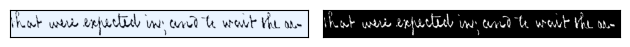

In [98]:
visu.plot([validation_dataset[2][1],validation_dataset[2][-1]])

In [99]:
data = validation_dataset[2][0].unsqueeze(0)

In [100]:
data.shape

torch.Size([1, 3, 120, 1313])

In [101]:
with torch.no_grad():
    reconstructed_image = model(data.cuda())

/home/cboned/miniconda3/envs/tfm/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)



In [102]:
reconstructed_image.shape

torch.Size([1, 3, 120, 1313])

In [103]:
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

In [104]:
unnormalized = data.squeeze() * std + mean

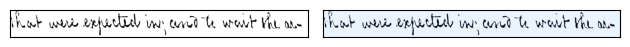

In [105]:
visu.plot([unnormalized, data.squeeze()])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


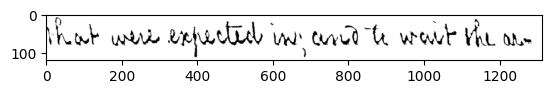

In [106]:
plt.imshow(unnormalized.permute(1, 2, 0))
plt.show()

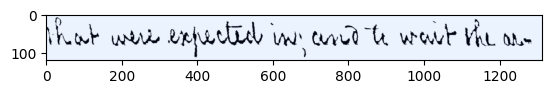

In [107]:
plt.imshow(data.squeeze().permute(1, 2, 0))
plt.show()

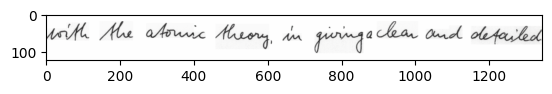

In [20]:
plt.imshow(reconstructed_image.squeeze().cpu().permute(1, 2, 0))
plt.show()

In [21]:
@torch.no_grad()
def extract_embeddings_from_visual_encoder(loader:Type[torch.utils.data.DataLoader],
                                           model: Type[nn.Module]) -> Float[Array, "Total_Images embed_dim"]:
    
    model.eval()
    final_embeddings = None
    
    for idx, batch in tqdm.tqdm(enumerate(loader), desc="Extracting Embeddings", leave=True, position=1):
        images = batch["image_lines"].to(device)

        embedding, _ = model.encoder(images)
        if final_embeddings is None:
            final_embeddings = embedding
        else:
            final_embeddings = torch.vstack((final_embeddings, embedding))

    final_embeddings = final_embeddings.cpu().numpy()

    return final_embeddings


@torch.no_grad()
def extract_intra_cluster_nearest_neighboors_at_k(x: torch.Tensor,
                                                  top_k=10):
    #Graph = utils.read_pickle("pickles/graphset_3_volumes_128_entities_4.pkl")

    dict_nearest_neighbors = {}
    distances_dict = {}
    distances = torch.cdist(x, x, p=2)
    
    # Set the diagonal to a large positive number to avoid self-matching
    distances.fill_diagonal_(float('inf'))
    # Get the top K nearest neighbors for each embedding (smallest distances)
    top_k_values, top_k_indices = torch.topk(distances, top_k, dim=1, largest=False)

    # Create a dictionary mapping each index to its top K nearest neighbors
    nearest_neighbors = {ix: top_k_indices[ix].tolist() for ix in range(distances.size(0))}


    return nearest_neighbors, distances    





In [108]:
len(infer_dataloader)
print(len(merged_dataset))

656


In [113]:
embeddings = extract_embeddings_from_visual_encoder(loader=infer_dataloader, model=model)

Extracting Embeddings: 656it [00:53, 12.21it/s]


## Plotting Section

In [110]:
import umap
import umap.plot as uplt

In [114]:
nearest_neigboors_dict = extract_intra_cluster_nearest_neighboors_at_k(torch.from_numpy(embeddings), 10)

In [115]:
targets = np.zeros(len(nearest_neigboors_dict[0]))

In [116]:
target_index = 0


In [117]:
mapper = umap.UMAP().fit(embeddings)


/home/cboned/miniconda3/envs/tfm/lib/python3.10/site-packages/umap/plot.py:449: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



<Axes: >

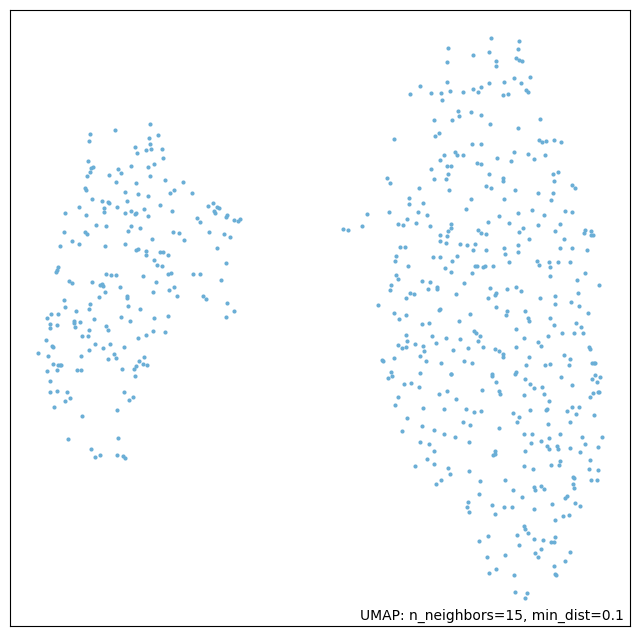

In [118]:
uplt.points(mapper)

In [119]:
embeddings.shape

(656, 300)

In [120]:


from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_cols = len(imgs)
    num_rows = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for col_idx, row in enumerate(imgs):
        for row_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()
    plt.show()
    #plt.savefig("dummy_example_batch.png")

In [121]:
import networkx as nx

In [222]:
def softmax(x):
    exp_x = torch.exp(-x)  # Apply negative to make smaller distances higher probabilities
    return exp_x / torch.sum(exp_x)

def reciprocal_knn_graph(nearest_neighbors, distance_matrix):
    G = nx.Graph()  # Initialize an empty graph
    triplets = []

    for i, neighbors in nearest_neighbors.items():
        # Get distances from point i to its neighbors
        distances_i = distance_matrix[i, neighbors]
        # Compute softmax for distances from i to neighbors
        probs_i = softmax(distances_i)
        G.add_node(i, dataset_index=i, label=str(i))
        
        for idx, neighbor in enumerate(neighbors):
            G.add_node(neighbor, dataset_index=neighbor, label=str(neighbor))

            # Get the reverse nearest neighbors from the other node
            if i in nearest_neighbors[neighbor]:
                # Get distances from neighbor to i and compute softmax
                distances_j = distance_matrix[neighbor, nearest_neighbors[neighbor]]
                probs_j = softmax(distances_j)
                
                # Multiply softmax probabilities from both directions
                weight = probs_i[idx] * probs_j[nearest_neighbors[neighbor].index(i)]
                weight = weight**(-1)
                
                # Add the edge to the graph
                G.add_edge(i, neighbor, weight=weight.item())
                
                # Store the triplet (i, weight, neighbor)
                triplets.append((i, weight.item(), neighbor))

    return triplets, G

In [223]:
def compute_dijkstra(graph, source, target):
    try:
        # Compute the shortest path between source and target using Dijkstra's algorithm
        path = nx.dijkstra_path(graph, source=source, target=target, weight='weight')
        # Compute the total path length
        path_length = nx.dijkstra_path_length(graph, source=source, target=target, weight='weight')
        
        return path, path_length
    except nx.NetworkXNoPath:
        return None, float('inf')  # If no path exists

In [224]:
def export_graph(graph, file_path='graph.gexf', format='gexf'):
    """
    Exports the NetworkX graph to a file in the specified format.
    Supported formats: 'gexf', 'graphml'
    """
    if format == 'gexf':
        nx.write_gexf(graph, file_path)
    elif format == 'graphml':
        nx.write_graphml(graph, file_path)
    else:
        raise ValueError(f"Unsupported format '{format}'. Use 'gexf' or 'graphml'.")


In [225]:
nearest_neighbors, distance_matrix = nearest_neigboors_dict

In [226]:
triplets, graph = reciprocal_knn_graph(nearest_neighbors, distance_matrix)

In [227]:
triplets

[(0, 86.0042953491211, 387),
 (0, 71.36604309082031, 494),
 (0, 92.5157241821289, 220),
 (1, 73.63579559326172, 409),
 (1, 91.49208068847656, 433),
 (1, 97.9470443725586, 150),
 (2, 49.316349029541016, 622),
 (2, 98.31563568115234, 131),
 (2, 111.13636779785156, 96),
 (3, 66.72257232666016, 65),
 (3, 115.61901092529297, 143),
 (3, 122.0799560546875, 448),
 (4, 76.19778442382812, 34),
 (4, 98.60783386230469, 413),
 (4, 89.2448959350586, 134),
 (4, 89.83538818359375, 91),
 (4, 127.26602935791016, 99),
 (5, 58.615501403808594, 410),
 (5, 114.96234130859375, 419),
 (5, 136.6126708984375, 417),
 (5, 120.64093017578125, 184),
 (7, 52.95720672607422, 290),
 (7, 140.3930206298828, 551),
 (8, 54.5484733581543, 617),
 (8, 71.93431854248047, 593),
 (8, 106.36988830566406, 410),
 (8, 148.5458984375, 563),
 (8, 122.02287292480469, 117),
 (9, 70.99726104736328, 21),
 (9, 70.8215560913086, 112),
 (9, 100.2291259765625, 132),
 (9, 112.63748168945312, 144),
 (9, 127.99478149414062, 471),
 (11, 38.18511

In [228]:
export_graph(graph=graph, format="gexf")

In [229]:
graph

In [219]:
nearest_neigboors_dict[1]

tensor([[    inf, 12.2677, 13.1379,  ..., 32.5620, 13.2959, 20.2685],
        [12.2677,     inf, 12.1762,  ..., 32.8384, 12.4466, 20.2467],
        [13.1379, 12.1762,     inf,  ..., 34.4115, 12.9827, 21.5005],
        ...,
        [32.5620, 32.8384, 34.4115,  ...,     inf, 29.7039, 21.5052],
        [13.2959, 12.4466, 12.9827,  ..., 29.7038,     inf, 18.2014],
        [20.2684, 20.2468, 21.5005,  ..., 21.5052, 18.2014,     inf]])

In [230]:
path, length_path = compute_dijkstra(graph=graph, source=612, target=655)

In [231]:
path

[612, 356, 361, 137, 655]

In [232]:
length_path

388.3444595336914

In [233]:
to_plot = []
for i in path:
    to_plot.append(merged_dataset[i][1]*std + mean)

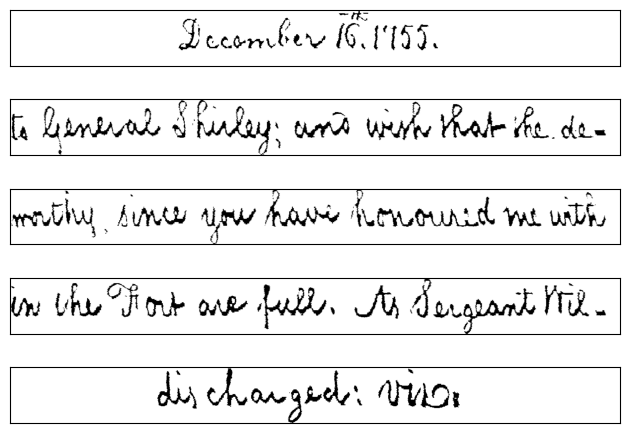

In [234]:
plot(to_plot) 

## Exaplaining

In [ ]:
class SimilarityToConcept():
    
    
    def __init__(self,  comparer_embedding, specfic_attribute):
        self._comparer_embedding = comparer_embedding.to(device)
        self._comparer_attribute = specfic_attribute
        
        
    def __call__(self, model_outputs):
        (reconstructed_image)= model_outputs

        euclidean_distance = torch.nn.functional.mse_loss(reconstructed_image, self._comparer_embedding[None], p=2)

        return euclidean_distance

In [ ]:
target_layers = [model._edge_encoder._conv3]
targets = [SimilarityToConcept(comparer_embedding=attribute_embeddings[504][0].cuda(), specfic_attribute=0)]
#language_embeddings[669]
reference_image = image_dataset[5512]
reference_image[0].shape